In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from src.data_reading import parse_galaxy_data
from src.data_treatment_tools import add_radian_columns, new_CoM_procedure 
import matplotlib as mpl

In [2]:
mpl.rcParams['font.size'] = 12  # Taille générale
mpl.rcParams['axes.titlesize'] = 16  # Taille des titres des graphiques
mpl.rcParams['axes.labelsize'] = 14  # Taille des labels des axes
mpl.rcParams['xtick.labelsize'] = 12  # Taille des étiquettes de l'axe x
mpl.rcParams['ytick.labelsize'] = 12  # Taille des étiquettes de l'axe y
mpl.rcParams['legend.fontsize'] = 12  # Taille de la légende
mpl.rcParams['figure.titlesize'] = 18  # Taille du titre de la figure

In [3]:
# G= 6.674 * 10**(-11)
G = 4.3009e-9  # Constante gravitationnelle en (km/s)² Mpc / M☉
galaxy_1_CoM =  "N5128,Cen A"
galaxy_2_CoM =  "N5236, M83"
r=0.76

In [4]:
file_path = 'data/data_clean.txt'
galaxy_df = parse_galaxy_data(file_path)
add_radian_columns(galaxy_df)
# galaxy_df.to_csv("test.csv")

In [6]:
new_CoM_procedure(galaxy_df,galaxy1=galaxy_1_CoM,galaxy2=galaxy_2_CoM,m1_barre=r,grid_incertainty=True)

c:\Users\Adrian\Documents\X\Stage 3A recherche\projet\project_3A\src\data_treatment_tools.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '300.19228135818446' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[len(df)] = new_row


CoM_N5128,Cen A_N5236, M83_0.76


# Mass calculation

In [7]:
### cuts
velocity_max = 200
velocity_min = -200

distance_max = 1


### Virial Mass

In [8]:
def Viriel_Mass(df,velocity, galaxy_excluded,row_name="CoM_N5128,Cen A_N5236, M83_0.76"):
    mask = (
    (~df['Name'].str.startswith('CoM_')) & 
    (~df['Name'].isin(galaxy_excluded))  &
    (df[velocity+"_"+row_name] >= velocity_min)  &
    (df[velocity+"_"+row_name] <= velocity_max)   &
    (df["dis_center_"+row_name]<= distance_max)
    )
    sigma_v=(df[mask][velocity+"_"+row_name] ** 2).mean()
    R_g=1/((1/df[mask]["dis_center_"+row_name]).mean())
    return (3/G)*sigma_v*R_g

In [9]:
M_minor= Viriel_Mass(galaxy_df,velocity="minor_infall_velocity",galaxy_excluded=[galaxy_1_CoM,galaxy_2_CoM])
M_major= Viriel_Mass(galaxy_df,velocity="major_infall_velocity",galaxy_excluded=[galaxy_1_CoM,galaxy_2_CoM])
print(f"The Virial Mass according to the minor infall model with a bound system of {distance_max} Mpc is: {M_minor:.2e} M_⊙")
print(f"The Virial Mass according to the major infall model with a bound system of {distance_max} Mpc is: {M_major:.2e} M_⊙")

The Virial Mass according to the minor infall model with a bound system of 1 Mpc is: 2.87e+12 M_⊙
The Virial Mass according to the major infall model with a bound system of 1 Mpc is: 4.77e+12 M_⊙


### Projected Mass

In [10]:
def projected_mass(df,velocity, galaxy_excluded,row_name="CoM_N5128,Cen A_N5236, M83_0.76",C=64/np.pi):
    mask = (
    (~df['Name'].str.startswith('CoM_')) & 
    (~df['Name'].isin(galaxy_excluded))  &
    (df[velocity+"_"+row_name] >= velocity_min)  &
    (df[velocity+"_"+row_name] <= velocity_max)   &
    (df["dis_center_"+row_name]<= distance_max)
    )
    mean=((df[mask][velocity+"_"+row_name] ** 2)*df[mask]["dis_center_"+row_name]).mean()
    return (C/G)*mean

In [11]:
M_major= projected_mass(galaxy_df,velocity="major_infall_velocity",galaxy_excluded=[galaxy_1_CoM,galaxy_2_CoM])
M_minor= projected_mass(galaxy_df,velocity="minor_infall_velocity",galaxy_excluded=[galaxy_1_CoM,galaxy_2_CoM])
print(f"The Projected Mass according to the minor infall model with a bound system of {distance_max} Mpc is: {M_minor:.2e} M_⊙")
print(f"The Projected Mass according to the major infall model with a bound system of {distance_max} Mpc is: {M_major:.2e} M_⊙")

The Projected Mass according to the minor infall model with a bound system of 1 Mpc is: 2.04e+13 M_⊙
The Projected Mass according to the major infall model with a bound system of 1 Mpc is: 3.47e+13 M_⊙


# Frequency analysis

In [77]:
def sample_asymmetric_gaussian(mean, sigma_minus, sigma_plus, size=1):
    u = np.random.rand(size)
    sigma = np.where(u < sigma_minus / (sigma_minus + sigma_plus), sigma_minus, sigma_plus)
    direction = np.where(u < sigma_minus / (sigma_minus + sigma_plus), -1, 1)
    return mean + direction * np.abs(np.random.normal(0, sigma, size))

def virial_mass_monte_carlo(df, velocity, galaxy_excluded, row_name="CoM_N5128,Cen A_N5236, M83_0.76",
                             velocity_min=-np.inf, velocity_max=np.inf, distance_max=np.inf,
                             N_samples=1000):

    
    # Apply the same filtering mask
    vel_col = velocity + "_" + row_name
    dis_col = "dis_center_" + row_name
    e_min_vel_col = "e_min_" + vel_col
    e_min_dis_col = "e_min_" + dis_col
    e_max_vel_col = "e_max_" + vel_col
    e_max_dis_col = "e_max_" + dis_col

    mask = (
        (~df['Name'].str.startswith('CoM_')) &
        (~df['Name'].isin(galaxy_excluded)) &
        (df[vel_col] >= velocity_min) &
        (df[vel_col] <= velocity_max) &
        (df[dis_col] <= distance_max) &
        (df[e_max_dis_col].notna()) &
        (df[e_max_vel_col].notna()) &
        (df[e_min_dis_col].notna()) &
        (df[e_min_vel_col].notna())
    )

    df_filtered = df[mask].copy()
    virial_masses = []
    for _ in range(N_samples):
        # Randomly sample velocity and distance with Gaussian noise
        sampled_vel = sample_asymmetric_gaussian(
            df_filtered[vel_col].values,
            df_filtered[e_min_vel_col].values,
            df_filtered[e_max_vel_col].values,
            size=len(df_filtered)
        )
        
        sampled_dis = sample_asymmetric_gaussian(
            df_filtered[dis_col].values,
            df_filtered[e_min_dis_col].values,
            df_filtered[e_max_dis_col].values,
            size=len(df_filtered)
        )
        # Avoid division by zero or negative distances
        sampled_dis = np.clip(sampled_dis, 1e-3, None)
        print(sampled_dis)
        # Compute sigma_v and R_g for this sample

        sigma_v = (sampled_vel ** 2).mean()
        R_g = 1 / ((1 / sampled_dis).mean())
        M_vir = (3 / G) * sigma_v * R_g
        virial_masses.append(M_vir)

    # Plot histogram

    # Convert to NumPy array and drop values outside the range
    virial_masses = np.array(virial_masses)
    virial_masses = virial_masses[(virial_masses > 0) & (virial_masses <= 2e12)]
    median = np.median(virial_masses)
    sigma = np.std(virial_masses)
    
    print(f"Median Virial Mass: {median:.2e} Msun")
    print(f"Standard Deviation (σ): {sigma:.2e} Msun")
    # Define bin edges linearly spaced from 0 to 1e13
    bins = np.linspace(0, 2e12, 100)

    # Plot the histogram
    plt.figure(figsize=(8, 5))
    plt.hist(virial_masses, bins=bins, color='steelblue', edgecolor='k')
    plt.xlabel('Virial Mass [Msun]')
    plt.ylabel('Frequency')
    plt.xlim(0, 2e12)  # Optional: narrower x-axis for better visibility
    plt.title('Monte Carlo Simulation of Virial Mass')
    plt.grid(True)
    plt.show()

    return virial_masses


Median Virial Mass: 7.64e+11 Msun
Standard Deviation (σ): 1.95e+11 Msun


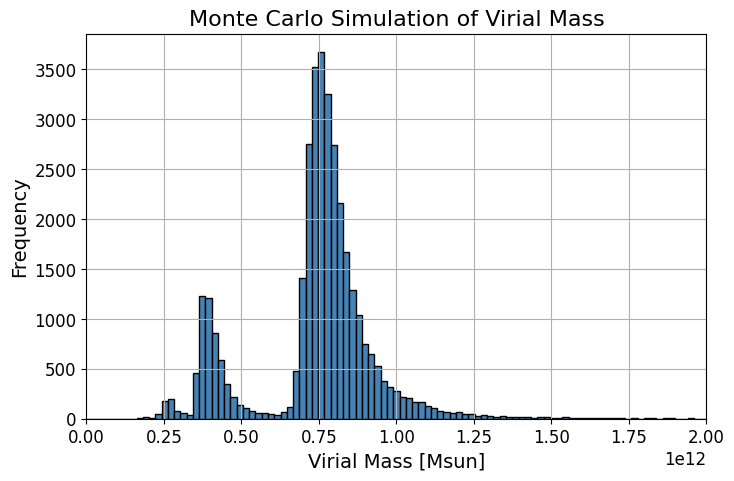

In [75]:
masses = virial_mass_monte_carlo(galaxy_df, velocity="minor_infall_velocity", galaxy_excluded=[galaxy_1_CoM,galaxy_2_CoM])

[4.19233836 3.30664532 3.68668739 4.42351248 3.23614666 3.73894812
 2.35276515 3.35495992 2.25484745 1.61769536 1.99863263 2.90782416
 1.52829958 1.68218559 2.52984997 2.11223562 3.83056592 1.46688901
 1.66554474 1.29232812 0.98858418 0.68001435 1.22581858 1.10204023
 0.84262165 1.77040196 1.49947411 1.17819643 1.12682426 2.98032366
 0.65383066 1.66570943 1.57241418 1.17122115 1.00990487 0.71112871
 1.82850532 0.6849467  0.50537106 2.04962303 1.06192837 0.92063448
 2.86681937 1.44009684 1.45614198 2.16715795 3.20163647 1.10386246
 2.54473515 1.86446773 2.54414137 3.53087941 3.92969782]
[3.96391875 3.03118959 3.53051199 3.80078479 3.70322605 4.03531983
 2.40855037 4.28514292 2.22472594 2.4268144  1.27470958 3.54142167
 1.9288897  2.38080844 2.51502998 1.38018449 2.71239775 3.63305096
 1.0643414  0.84583922 0.75907517 2.67345147 1.21105693 0.30012589
 0.62120703 0.7313249  0.80764079 1.46334177 3.01689224 0.83785375
 1.12882043 1.22654385 0.42158229 1.98794058 0.86365754 1.70109584
 1.38

C:\Users\Adrian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Adrian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Adrian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Adrian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:175: RuntimeWarning: invalid va

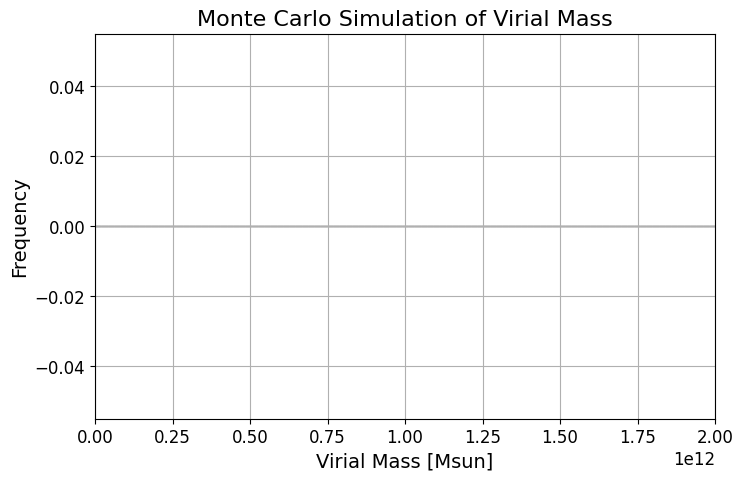

In [78]:
masses = virial_mass_monte_carlo(galaxy_df, velocity="major_infall_velocity_bis", galaxy_excluded=[galaxy_1_CoM,galaxy_2_CoM])

# Hubble Law

In [4]:
force_origin=False
mask1= ~galaxy_df['Name'].str.startswith('CoM_')
mask2 = (
    (galaxy_df["dis_center_CoM_N5128,Cen A_N5236, M83_0.76"] >= 2) &
    (galaxy_df["minor_infall_velocity_CoM_N5128,Cen A_N5236, M83_0.76"] >= -100) & (galaxy_df["minor_infall_velocity_CoM_N5128,Cen A_N5236, M83_0.76"] <= 350) &
    ~galaxy_df['Name'].str.startswith('CoM_')
    )
D_obs = pd.to_numeric(galaxy_df.loc[mask2, "dis_center_CoM_N5128,Cen A_N5236, M83_0.76"], errors='coerce').values
V_obs = pd.to_numeric(galaxy_df.loc[mask2, "minor_infall_velocity_CoM_N5128,Cen A_N5236, M83_0.76"], errors='coerce').values

valid_mask = (~np.isnan(D_obs) &
              ~np.isnan(V_obs) 
)
    
data_D=pd.to_numeric(galaxy_df.loc[mask1, "dis_center_CoM_N5128,Cen A_N5236, M83_0.76"], errors='coerce').values
data_V= pd.to_numeric(galaxy_df.loc[mask1, "minor_infall_velocity_CoM_N5128,Cen A_N5236, M83_0.76"], errors='coerce').values       
D_obs_clean = D_obs[valid_mask]
V_obs_clean = V_obs[valid_mask]

NameError: name 'galaxy_df' is not defined

In [ ]:
# expected plot
x_exp = np.linspace(0, D_obs_clean.max(), 100)
y_exp = ((1.2+0.31*0.67)/0.96)*70*x_exp -np.sqrt(G*(10**13)/x_exp)

C:\Users\Adrian\AppData\Local\Temp\ipykernel_22460\26976062.py:3: RuntimeWarning: divide by zero encountered in divide
  y_exp = ((1.2+0.31*0.67)/0.96)*70*x_exp -np.sqrt(G*(10**13)/x_exp)


(-100.0, 500.0)

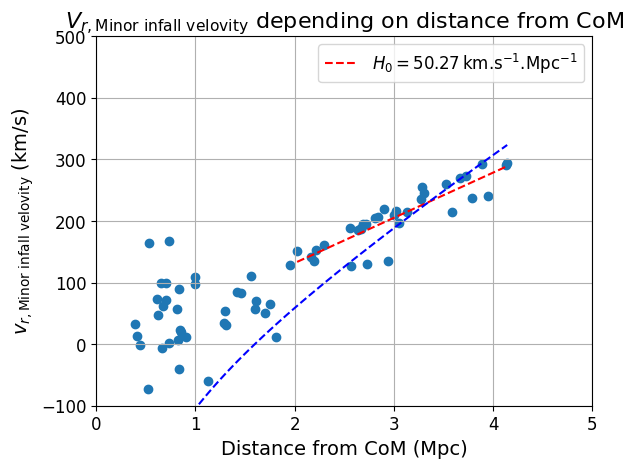

In [ ]:

    # trace de la regression
    if force_origin:
        A = D_obs_clean.reshape(-1, 1)
        a = np.linalg.lstsq(A, V_obs_clean, rcond=None)[0][0]
        b = 0
    else:
        A = np.vstack([D_obs_clean, np.ones(len(D_obs_clean))]).T
        a, b = np.linalg.lstsq(A, V_obs_clean, rcond=None)[0]
    x_vals = np.linspace(D_obs_clean.min(), D_obs_clean.max(), 100)
    y_vals = a * x_vals + b
    
    plt.scatter(data_D,data_V)
    plt.plot(x_vals, y_vals, 'r--', label=f"$H_0 = {a*(0.96/(1.2+0.3*0.67)):.2f}\\, \\text{{km.s}}^{{-1}}\\text{{.Mpc}}^{{-1}}$")
    plt.plot(x_exp, y_exp, 'b--')
    plt.xlabel("Distance from CoM (Mpc)")
    plt.ylabel(r"$v_{r,\text{Minor infall velovity}}$ (km/s)")
    plt.title(r"$V_{r,\text{Minor infall velovity}}$ depending on distance from CoM")
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 5)  # Limites de l'axe x entre 1 et 5
    plt.ylim(-100, 500)  # Limites de l'axe y entre -25 et 20

In [ ]:
force_origin=False
mask1= ~galaxy_df['Name'].str.startswith('CoM_')
mask2 = (
    (galaxy_df["dis_center_CoM_N5128,Cen A_N5236, M83_0.76"] >= 0) &
    (galaxy_df["major_infall_velocity_CoM_N5128,Cen A_N5236, M83_0.76"] >= -100) & (galaxy_df["major_infall_velocity_CoM_N5128,Cen A_N5236, M83_0.76"] <= 350) &
    ~galaxy_df['Name'].str.startswith('CoM_')
    )
D_obs = pd.to_numeric(galaxy_df.loc[mask2, "dis_center_CoM_N5128,Cen A_N5236, M83_0.76"], errors='coerce').values
V_obs = pd.to_numeric(galaxy_df.loc[mask2, "major_infall_velocity_CoM_N5128,Cen A_N5236, M83_0.76"], errors='coerce').values

valid_mask = (~np.isnan(D_obs) &
              ~np.isnan(V_obs) 
)
    
data_D=pd.to_numeric(galaxy_df.loc[mask1, "dis_center_CoM_N5128,Cen A_N5236, M83_0.76"], errors='coerce').values
data_V= pd.to_numeric(galaxy_df.loc[mask1, "major_infall_velocity_CoM_N5128,Cen A_N5236, M83_0.76"], errors='coerce').values       
D_obs_clean = D_obs[valid_mask]
V_obs_clean = V_obs[valid_mask]

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Pour cet exemple, supposons que nous avons un DataFrame avec deux colonnes: 'distance' et 'velocity'
# df = pd.read_csv('votre_fichier.csv')  # Décommentez pour utiliser votre propre fichier
# Exemple de données (à remplacer par vos propres données)

# Notre modèle basé sur votre équation
def velocity_model(r, H0, M):
    """
    r: distance en mètres
    H0: constante de Hubble en s⁻¹
    M: masse en kg
    Ω_Λ = 0.67 (fixé)
    
    Retourne la vitesse prédite en m/s
    """
    Omega_Lambda = 0.67
    t0 = 0.96 / H0
    
    term1 = H0* (1.1 + 0.31 * Omega_Lambda  ) * r 
    term2 = 1.1 * np.sqrt(G * M / r)
    
    return term1 - term2 
    #return 1.2*r*H0-term2

# Fonction d'ajustement
def fit_model(df, velocity,row_name="CoM_N5128,Cen A_N5236, M83_0.76"):
    mask = (
    (~df['Name'].str.startswith('CoM_')) & 
    (df[velocity+"_"+row_name] >= -100)  &
    (df[velocity+"_"+row_name] <= 500)   &
    (df["dis_center_"+row_name]> 1)
    )
    r = df[mask]["dis_center_"+row_name]
    v_obs = df[mask][velocity+"_"+row_name]
    
    # Valeurs initiales pour H0 et M
    # H0 initial: ~70 km/s/Mpc converti en s⁻¹
    # M initial: ~10^42 kg (ordre de grandeur de masse galactique)
    initial_guess = [70, 1e12]
    
    # Limites pour les paramètres (H0 > 0, M > 0)
    bounds = ([0, 0], [np.inf, np.inf])
    
    try:
        params, covariance = curve_fit(velocity_model, r, v_obs, p0=initial_guess, bounds=bounds)
        H0, M = params

        
        # Calcul des erreurs standard
        perr = np.sqrt(np.diag(covariance))
        H0_err, M_err = perr

        
        # Calcul du R² pour évaluer la qualité de l'ajustement
        v_pred = velocity_model(r, H0, M)
        ss_res = np.sum((v_obs - v_pred) ** 2)
        ss_tot = np.sum((v_obs - np.mean(v_obs)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        return {
            'H0': H0,
            'M': M,
            'H0_err': H0_err,
            'M_err': M_err,
            'r_squared': r_squared
        }
    
    except RuntimeError as e:
        print(f"Erreur lors de l'ajustement: {e}")
        return None

# Visualisation des résultats
def plot_results(df, params, velocity, row_name="CoM_N5128,Cen A_N5236, M83_0.76"):
    mask = (
    (~df['Name'].str.startswith('CoM_')) & 
    (df[velocity+"_"+row_name] >= -100)  &
    (df[velocity+"_"+row_name] <= 500) 

    )
    r = df[mask]["dis_center_"+row_name]
    v_obs = df[mask][velocity+"_"+row_name]
    
    # Générer des points pour la courbe d'ajustement
    r_smooth = np.linspace(min(r), max(r), 1000)
    v_pred = velocity_model(r_smooth, params['H0'], params['M'])
    
    plt.figure(figsize=(10, 6))
    plt.scatter(r, v_obs, label='Données observées', color='blue')
    plt.plot(r_smooth, v_pred, label='Modèle ajusté', color='red')
    
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Vitesse (km/s)')
    plt.title(f'Ajustement du modèle cosmologique\nH₀ = {params["H0"]:.2f} ± {params["H0_err"]:.2f} km/s/Mpc, '
              f'M = {params["M"]:.2e} ± {params["M_err"]:.2e} M_⊙\nR² = {params["r_squared"]:.4f}')
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Résultats de l'ajustement:
H₀ = 59.25 ± 8.21 km/s/Mpc
M = 1.2465e+12 ± 1.4089e+12 M_⊙
Coefficient de détermination (R²): 0.4136


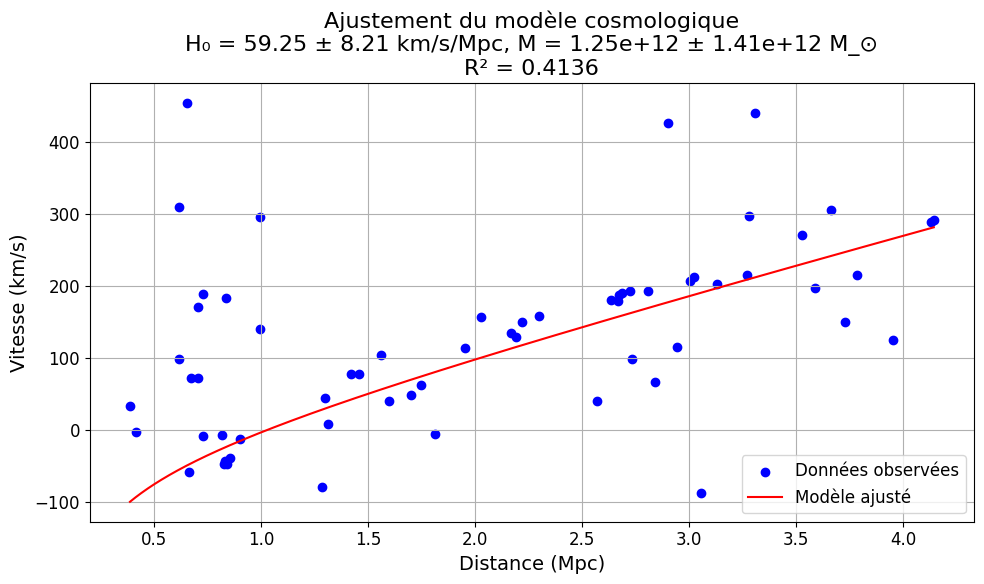

In [ ]:
# Exécution du code et affichage des résultats
results = fit_model(galaxy_df,velocity="major_infall_velocity")
if results:
    print(f"Résultats de l'ajustement:")
    print(f"H₀ = {results['H0']:.2f} ± {results['H0_err']:.2f} km/s/Mpc")
    print(f"M = {results['M']:.4e} ± {results['M_err']:.4e} M_⊙")
    print(f"Coefficient de détermination (R²): {results['r_squared']:.4f}")
    
    plot_results(galaxy_df,results,velocity="major_infall_velocity")

In [ ]:

    # trace de la regression
if force_origin:
    A = D_obs_clean.reshape(-1, 1)
    a = np.linalg.lstsq(A, V_obs_clean, rcond=None)[0][0]
    b = 0
else:
    A = np.vstack([D_obs_clean, np.ones(len(D_obs_clean))]).T
    a, b = np.linalg.lstsq(A, V_obs_clean, rcond=None)[0]
x_vals = np.linspace(D_obs_clean.min(), D_obs_clean.max(), 100)
y_vals = a * x_vals + b

plt.scatter(data_D,data_V)
#plt.plot(x_vals, y_vals, 'r--', label=f"$H_0 = {a:.2f}\\, \\text{{km.s}}^{{-1}}\\text{{.Mpc}}^{{-1}}$")
plt.plot(x_vals, y_vals, 'r--', label=f"$H_0 = {a/(1.2+0.3*0.67):.2f}\\, \\text{{km.s}}^{{-1}}\\text{{.Mpc}}^{{-1}}$")
plt.xlabel("Distance from CoM (Mpc)")
plt.ylabel(r"$v_{r,\text{Major infall velovity}}$ (km/s)")
plt.title(r"$V_{r,\text{Major infall velovity}}$ depending on distance from CoM")
plt.legend()
plt.grid(True)
plt.xlim(0, 5)  # Limites de l'axe x entre 1 et 5
plt.ylim(-100, 500)  # Limites de l'axe y entre -25 et 20

IndentationError: expected an indented block after 'if' statement on line 2 (1067857628.py, line 3)

In [ ]:
def D_LT(theta, R0):
    pi_23 = np.pi ** (2/3)
    if theta < 0:
        num = 1 - np.cos(theta)
        den = (theta - np.sin(theta)) ** (2/3)
    else:
        num = np.cosh(theta) - 1
        den = (np.sinh(theta) - theta) ** (2/3)
    return (pi_23 / 2) * R0 * (num / den)

def V_LT(theta, R0, T0):
    pi_23 = np.pi ** (2/3)
    if theta < 0:
        num = np.sin(theta) * (theta - np.sin(theta)) ** (1/3)
        den = 1 - np.cos(theta)
    else:
        num = np.sinh(theta) * (np.sinh(theta) - theta) ** (1/3)
        den = np.cosh(theta) - 1
    return (pi_23 / 2) * R0 / T0 * (num / den)


In [ ]:
def model_error(params, D_obs, V_obs):
    R0, T0 = params
    total_error = 0.0
    
    for D_i, V_i in zip(D_obs, V_obs):
        # Find theta that reproduces the observed D_i for given R0
        def d_residual(theta):
            try:
                return D_LT(theta, R0) - D_i
            except:
                return np.inf
        
        # Initial guess for theta: try positive and negative range
        result = root_scalar(d_residual, bracket=[-10, 10], method='brentq')
        if not result.converged:
            continue
        theta_i = result.root
        
        V_model = V_LT(theta_i, R0, T0)
        total_error += (V_model - V_i) ** 2  # squared error
        
    return total_error

In [ ]:
from scipy.optimize import minimize

# Initial guess for R0 and T0
initial_params = [1.0, 1.0]
result = minimize(model_error, initial_params, args=(D_obs_clean, V_obs_clean), method='Nelder-Mead')

R0_fit, T0_fit = result.x
print(f"Fitted parameters: R0 = {R0_fit:.4f}, T0 = {T0_fit:.4f}")

NameError: name 'root_scalar' is not defined

In [ ]:
theta_vals = np.linspace(-10, 10, 500)
D_model = [D_LT(t, R0_fit) for t in theta_vals]
V_model = [V_LT(t, R0_fit, T0_fit) for t in theta_vals]

plt.scatter(D_obs, V_obs, label='Observed data', color='black')
plt.plot(D_model, V_model, label='LT Model Fit', color='red')
plt.xlabel('Distance (Mpc)')
plt.ylabel('Velocity (km/s)')
plt.legend()
plt.show()

Starting optimization with multiple methods...
Trying optimization method: Nelder-Mead


C:\Users\Adrian\AppData\Local\Temp\ipykernel_15472\1860728252.py:10: RuntimeWarning: invalid value encountered in scalar power
  den = (theta - np.sin(theta)) ** (2/3)


Current params: R0=2.333115, T0=5.784225, Error=85865.374999, Valid points=1
Current params: R0=2.336691, T0=0.487599, Error=82849.996553, Valid points=1
Current params: R0=2.338046, T0=0.009414, Error=0.000150, Valid points=1
Current params: R0=2.338186, T0=0.009413, Error=0.000000, Valid points=1
New best result with Nelder-Mead: R0=2.3382, T0=0.0094, Error=0.0000
Trying optimization method: Powell


C:\Users\Adrian\AppData\Local\Temp\ipykernel_15472\1860728252.py:111: OptimizeWarning: Unknown solver options: xatol, fatol
  result = minimize(
C:\Users\Adrian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_optimize.py:2472: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)


Current params: R0=2.020260, T0=0.009756, Error=6749.998523, Valid points=8
Trying optimization method: BFGS
Current params: R0=1.987231, T0=13.797638, Error=631394.482365, Valid points=9
Current params: R0=1.991410, T0=13.798411, Error=563760.424766, Valid points=8


C:\Users\Adrian\AppData\Local\Temp\ipykernel_15472\1860728252.py:10: RuntimeWarning: invalid value encountered in scalar power
  den = (theta - np.sin(theta)) ** (2/3)


Current params: R0=1.990301, T0=13.798206, Error=631395.681025, Valid points=9
Fitted parameters: R0 = 2.3382, T0 = 0.0094
Optimization success: True
Optimization message: Optimization terminated successfully.


C:\Users\Adrian\AppData\Local\Temp\ipykernel_15472\1860728252.py:10: RuntimeWarning: invalid value encountered in scalar power
  den = (theta - np.sin(theta)) ** (2/3)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_15472\1860728252.py:20: RuntimeWarning: invalid value encountered in scalar power
  num = np.sin(theta) * (theta - np.sin(theta)) ** (1/3)


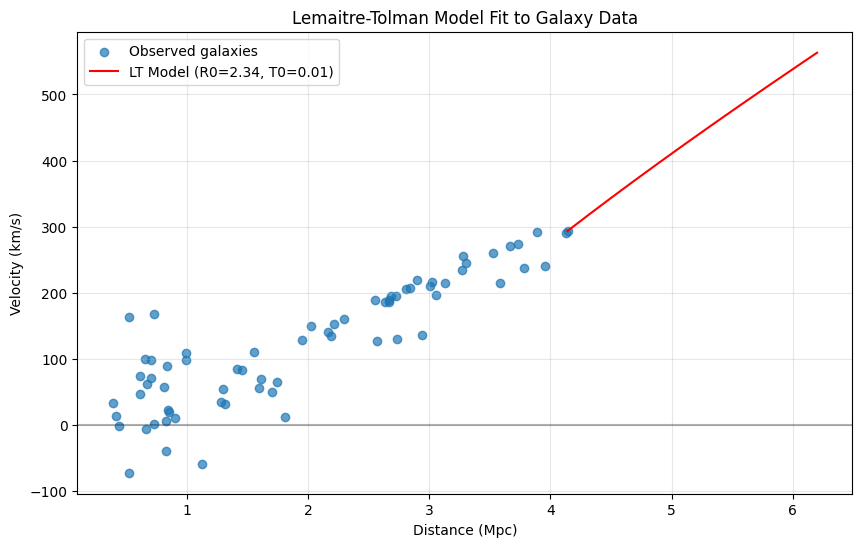

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, root_scalar

def D_LT(theta, R0):
    """Distance function for Lemaitre-Tolman model"""
    pi_23 = np.pi ** (2/3)
    if theta < 0:
        num = 1 - np.cos(theta)
        den = (theta - np.sin(theta)) ** (2/3)
    else:
        num = np.cosh(theta) - 1
        den = (np.sinh(theta) - theta) ** (2/3)
    return (pi_23 / 2) * R0 * (num / den)

def V_LT(theta, R0, T0):
    """Velocity function for Lemaitre-Tolman model"""
    pi_23 = np.pi ** (2/3)
    if theta < 0:
        num = np.sin(theta) * (theta - np.sin(theta)) ** (1/3)
        den = 1 - np.cos(theta)
    else:
        num = np.sinh(theta) * (np.sinh(theta) - theta) ** (1/3)
        den = np.cosh(theta) - 1
    return (pi_23 / 2) * R0 / T0 * (num / den)

def model_error(params, D_obs, V_obs):
    """Calculate error between model and observations"""
    R0, T0 = params
    if R0 <= 0 or T0 <= 0:
        return np.inf  # Penalize negative or zero parameters
    
    total_error = 0.0
    valid_points = 0
    
    for D_i, V_i in zip(D_obs, V_obs):
        # Find theta that reproduces the observed D_i for given R0
        def d_residual(theta):
            try:
                return D_LT(theta, R0) - D_i
            except:
                return np.inf
        
        try:
            # Expand search range for theta
            # First check if there's a sign change in the residual function
            sign_change = False
            for theta_min, theta_max in [(-20, -0.1), (0.1, 20)]:
                res_min = d_residual(theta_min)
                res_max = d_residual(theta_max)
                if res_min * res_max < 0:  # Sign change detected
                    sign_change = True
                    result = root_scalar(d_residual, bracket=[theta_min, theta_max], method='brentq')
                    if result.converged:
                        theta_i = result.root
                        
                        # Calculate model velocity and add squared error
                        V_model = V_LT(theta_i, R0, T0)
                        err = (V_model - V_i) ** 2  # squared error
                        total_error += err
                        valid_points += 1
                        break
            
            if not sign_change:
                # If no sign change, try more methods
                try:
                    result = root_scalar(d_residual, x0=1.0, x1=2.0, method='secant')
                    if result.converged:
                        theta_i = result.root
                        V_model = V_LT(theta_i, R0, T0)
                        err = (V_model - V_i) ** 2
                        total_error += err
                        valid_points += 1
                except:
                    pass
        except Exception as e:
            # Skip points where root finding fails
            continue
    
    # Return high error if no valid points were found
    if valid_points == 0:
        return np.inf
    
    # Print diagnostic information occasionally
    if np.random.random() < 0.01:  # Only print occasionally to avoid flooding
        print(f"Current params: R0={R0:.6f}, T0={T0:.6f}, Error={total_error:.6f}, Valid points={valid_points}")
    
    return total_error

# Filter and clean data
mask = ~galaxy_df['Name'].str.startswith('CoM_')
D_obs = pd.to_numeric(galaxy_df.loc[mask, "dis_center_CoM_N5128,Cen A_N5236, M83_0.76"], errors='coerce').values
V_obs = pd.to_numeric(galaxy_df.loc[mask, "minor_infall_velocity_CoM_N5128,Cen A_N5236, M83_0.76"], errors='coerce').values

valid_mask = ~np.isnan(D_obs) & ~np.isnan(V_obs)
D_obs_clean = D_obs[valid_mask]
V_obs_clean = V_obs[valid_mask]

# Initial guess for R0 and T0
initial_params = [2.0, 13.8]  # Better starting point (R0 in Mpc, T0 in Gyr)

# Try different optimization methods
methods = ['Nelder-Mead', 'Powell', 'BFGS']
best_result = None
best_error = np.inf

print("Starting optimization with multiple methods...")
for method in methods:
    try:
        print(f"Trying optimization method: {method}")
        result = minimize(
            model_error, 
            initial_params, 
            args=(D_obs_clean, V_obs_clean), 
            method=method,
            options={'maxiter': 5000, 'xatol': 1e-8, 'fatol': 1e-8}
        )
        
        if result.fun < best_error and result.success:
            best_result = result
            best_error = result.fun
            print(f"New best result with {method}: R0={result.x[0]:.4f}, T0={result.x[1]:.4f}, Error={result.fun:.4f}")
    except Exception as e:
        print(f"Method {method} failed: {str(e)}")

if best_result is not None:
    result = best_result
else:
    print("All optimization methods failed. Using last result.")

# Extract fitted parameters
R0_fit, T0_fit = result.x
print(f"Fitted parameters: R0 = {R0_fit:.4f}, T0 = {T0_fit:.4f}")
print(f"Optimization success: {result.success}")
print(f"Optimization message: {result.message}")

# Create model predictions for plotting
thetas = np.linspace(-5, 5, 1000)
D_model = np.array([D_LT(theta, R0_fit) for theta in thetas])
V_model = np.array([V_LT(theta, R0_fit, T0_fit) for theta in thetas])

# Filter model to reasonable range for plotting
plot_mask = (D_model > 0) & (D_model < max(D_obs_clean) * 1.5)
D_plot = D_model[plot_mask]
V_plot = V_model[plot_mask]

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(D_obs_clean, V_obs_clean, label='Observed galaxies', alpha=0.7)
plt.plot(D_plot, V_plot, 'r-', label=f'LT Model (R0={R0_fit:.2f}, T0={T0_fit:.2f})')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('Distance (Mpc)')
plt.ylabel('Velocity (km/s)')
plt.title('Lemaitre-Tolman Model Fit to Galaxy Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()